## BEATLEX_adb Trial with test data: Summarizing and Forecasting Time Series with Patterns

### Abstract
Given time-series data such as electrocardiogram (ECG) readings, or motion capture data, how can we succintly summarize the data in a way that robustly identifies patterns that appear repeatedly? How can we then use such a summary to identify anomalies such as abnormal heartbeats, and also forecast future values of the time series? Our main idea is a vocabulary-based approach, which automatically learns a set of common patterns, or ‘beat patterns,’ which are used as building blocks to describe the time series in an intuitive and interpretable way. Our summarization algorithm, BEATLEX (BEAT LEXicons for Summarization) is: 1) fast and online, requiring linear time in the data size and bounded memory; 2) effective, outperforming competing algorithms in labelling accuracy by 5.3 times, and forecasting accuracy by 1.8 times; 3) principled and parameterfree, as it is based on the Minimum Description Length principle of summarizing the data by compressing it using as few bits as possible, and automatically tunes all its parameters; 4) general: it applies to any domain of time series data, and can make use of multidimensional (i.e. coevolving) time series.

You can configure the backend to use GPU or CPU only. \
Default is using backend cpu. 

In [1]:
import sys
sys.path.append("C:/Users/bailean/Documents/Bitbucket-Projects/spartan2")

import spartan as st
import pandas as pd 

Using backend cpu


```loadTensor``` function automatically read data from file and ```toDTensor``` function extract time and value separately from the tensor.<br/>```Timeseries``` class is designed to construct time tensor.

labels=Index(['IB5Value', 'ESCBiasVoltage_AI V', 'TCPRFGenForwardPower_AI watt',
       'CurrentMMPPhase', 'BiasRFGenForwardPower_AI watt',
       'TCPMatchCurrentPhaseDifference_AI deg'],
      dtype='object'), code doesn't want time label which must be firt usecols index


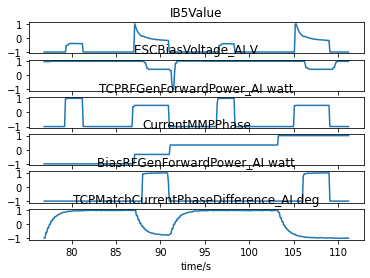

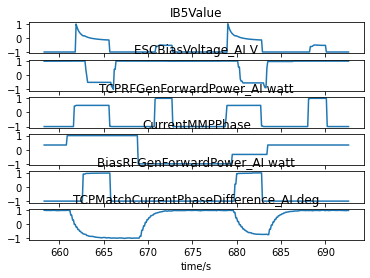

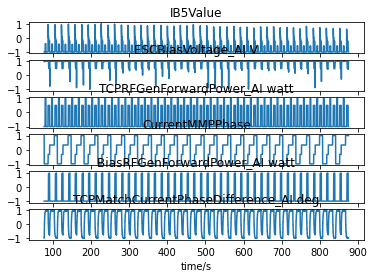

       Time  IB5Value  ESCBiasVoltage_AI V  TCPRFGenForwardPower_AI watt  \
0      76.8 -0.999651             0.959416                          -1.0   
1      76.9 -0.999633             0.959416                          -1.0   
2      77.0 -0.999654             0.959416                          -1.0   
3      77.1 -0.999569             0.959416                          -1.0   
4      77.2 -0.999600             0.959416                          -1.0   
...     ...       ...                  ...                           ...   
7984  875.2 -0.999583             0.947222                          -1.0   
7985  875.3 -0.999564             0.947222                          -1.0   
7986  875.4 -0.999636             0.947222                          -1.0   
7987  875.5 -0.999636             0.947222                          -1.0   
7988  875.6 -0.999637             0.947222                          -1.0   

      CurrentMMPPhase  BiasRFGenForwardPower_AI watt  \
0                 1.0          

In [2]:
fullset = 'inputData/LRCX-1/05-01-23_Dataset3_SJSUcase.csv'
subset = 'inputData/LRCX-1/05-01-23_DataSUBset3_SJSUcase.csv'
LRCXfilepath = subset
kwargs = {
        'header': 0,
        'usecols': [0, 60, 8, 13, 67, 61, 36]
                    #36, 38, 120, 77 ] # of interest for full dataset3
                    #60, 13,  67, 8 ] # corresponding for SUBset of dataset3  
                    #OES in subset [0,8,18,20,22,23,25,26,28,30,31,32,33]
        }
df = pd.read_csv(LRCXfilepath)
if not kwargs['usecols'] is None: 
        labels = df.columns[sorted(kwargs['usecols'][1:])]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **kwargs).toDTensor(hastticks=True)
else:
        kwargs.pop('usecols') 
        labels = df.columns[1:]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **{'header': 0}).toDTensor(hastticks=True)

print(f"{labels=}, code doesn't want time label which must be firt usecols index")
width = 342
for beat in [0,17]:
        if 1112 + width*beat < 8756:
                time_series = st.Timeseries(value, time, labels = labels).cut(start=768 + width*beat, end=1112 + width*beat, inplace=False).normalize(inplace=False)
                st.plot_timeseries(time_series)
time_series = st.Timeseries(value, time, labels = labels).cut(start=767, end=8756, inplace=False).normalize(inplace=False)
st.plot_timeseries(time_series)
print(f"time series {time_series}, type {type(time_series)}")

### Run Beatlex from specific task

In [3]:
ss_task = st.Summarization.create(time_series, st.SumPolicy.BeatLex, 'my_beatlex_model')

In [4]:
result = ss_task.run()

init at 179

========segment 2 at 180 479
cluster cost [0.51259593]
new cluster cost for 6: 1.3877861772866742
size chosen: 181
new_cluster
best_place: [179, 0, 180]
best_S1: 179
new cluster starts 180 ends 359

========segment 3 at 360 659
cluster cost [0.25479526 0.52429508]
new cluster cost for 6: 1.3877861772866742
size chosen: 180
new_cluster
best_place: [299, 0, 221]
best_S1: 299
new cluster starts 360 ends 659

========segment 4 at 660 959
cluster cost [0.12814058 0.6609352  1.95070709]
new cluster cost for 6: 1.3877861772866742
size chosen: 222
cluster 0

========segment 5 at 882 1181
cluster cost [0.50219227 0.01617011 1.41306727]
new cluster cost for 6: 1.3877861772866742
size chosen: 180
cluster 1

========segment 6 at 1062 1361
cluster cost [1.17648546 0.88723908 0.07234829]
new cluster cost for 6: 1.3877861772866742
size chosen: 299
cluster 2

========segment 7 at 1361 1660
cluster cost [0.14313493 0.65299393 2.01438807]
new cluster cost for 6: 1.3877861772866742
size chos

KeyboardInterrupt: 

### Run Beatlex as a single model

In [5]:
beatlex = st.BeatLex(time_series)
result = beatlex.run()

init at 179

========segment 2 at 180 479
cluster cost [0.51259593]
new cluster cost for 6: 1.3877861772866742
size chosen: 181
new_cluster
best_place: [179, 0, 180]
best_S1: 179
new cluster starts 180 ends 359

========segment 3 at 360 659
cluster cost [0.25479526 0.52429508]
new cluster cost for 6: 1.3877861772866742
size chosen: 180
new_cluster
best_place: [299, 0, 221]
best_S1: 299
new cluster starts 360 ends 659

========segment 4 at 660 959
cluster cost [0.12814058 0.6609352  1.95070709]
new cluster cost for 6: 1.3877861772866742
size chosen: 222
cluster 0

========segment 5 at 882 1181
cluster cost [0.50219227 0.01617011 1.41306727]
new cluster cost for 6: 1.3877861772866742
size chosen: 180
cluster 1

========segment 6 at 1062 1361
cluster cost [1.17648546 0.88723908 0.07234829]
new cluster cost for 6: 1.3877861772866742
size chosen: 299
cluster 2

========segment 7 at 1361 1660
cluster cost [0.14313493 0.65299393 2.01438807]
new cluster cost for 6: 1.3877861772866742
size chos

C:\Users/bailean/Documents/Bitbucket-Projects/spartan2\spartan\model\beatlex\Beatlex.py:73: RuntimeWarning: All-NaN slice encountered
  best_cost = np.nanmin(ave_costs)


best prefix found 0 nan 0.08465480241396636
ending with prefix [1]


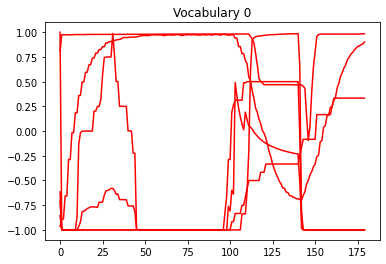

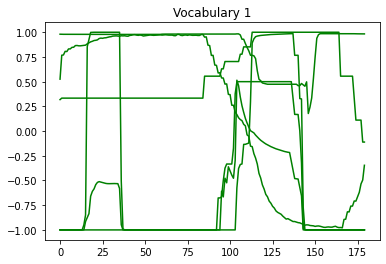

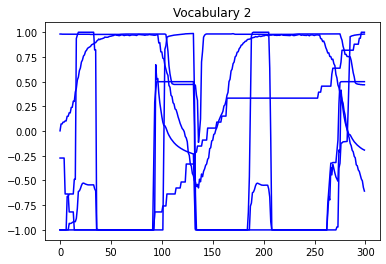

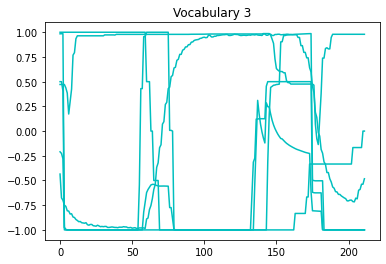

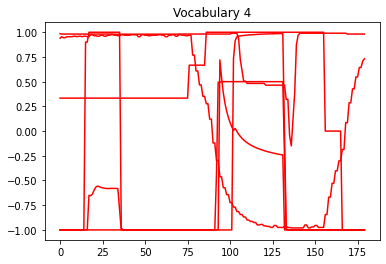

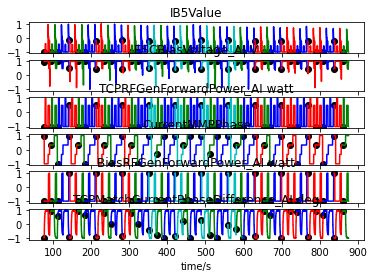

In [6]:
st.plot(st.BeatLex, time_series, result)

Vocabularies | Segmentation
:-------------------------:|:-------------------------:
<img src="images/beatlexSum1.png" width="300"/>  |   <img src="images/beatlexSum2.png" width="300"/>
<b>Vocabularies learned by BeatLex. |  <b>Segmentation made by BeatLex.

### Experiment Results
------
Beatlex(ECG)      |  Beatlex(Motion)
:-------------------------:|:-------------------------:
<img src="images/beatlexExp1.png" width="300"/>  |   <img src="images/beatlexExp2.png" width="300"/>
<b>Beatlex segments and labels data. |  <b>Beatlex learns vocabulary.

### Cite:
------
1. Hooi, Bryan, et al. "B eat L ex: Summarizing and Forecasting Time Series with Patterns." Joint European Conference on Machine Learning and Knowledge Discovery in Databases. Springer, Cham, 2017.

    <details>
    <summary><span style="color:blue">click for BibTex...</span></summary>

    ```bibtex
    @inproceedings{hooi2017b,
      title={B eat L ex: Summarizing and Forecasting Time Series with Patterns},
      author={Hooi, Bryan and Liu, Shenghua and Smailagic, Asim and Faloutsos, Christos},
      booktitle={Joint European Conference on Machine Learning and Knowledge Discovery in Databases},
      pages={3--19},
      year={2017},
      organization={Springer}
    }
    ```
    </details>